In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
WEIGHTS_PATH = f"/content/drive/MyDrive/mybest.pt"

Use custom model - single frame

In [ ]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

In [ ]:
SOURCE_VIDEO_PATH = f"/content/cut3.mp4"

In [ ]:

frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

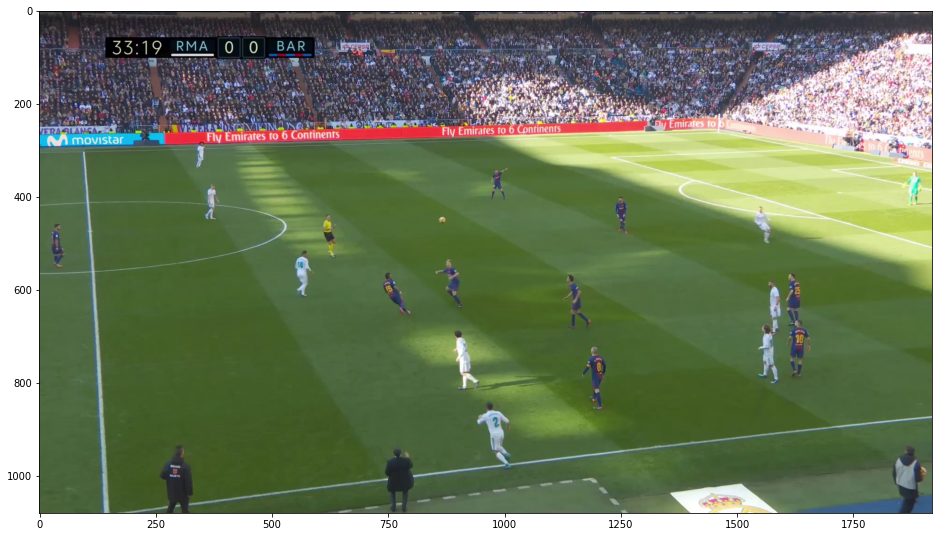

In [ ]:
frame = next(frame_iterator)
plot_image(frame, 16)

In [ ]:

import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device='cpu')

In [ ]:
results = model(frame, size=1280)

In [ ]:

results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1080x1920 1 ball, 2 goalkeepers, 18 players
Speed: 29.6ms pre-process, 15969.5ms inference, 21.6ms NMS per image at shape (1, 3, 768, 1280)

In [ ]:
results.pred[0]

tensor([[1.54464e+03, 6.73297e+02, 1.59165e+03, 8.02125e+02, 9.77102e-01, 2.00000e+00],
        [9.41182e+02, 8.40627e+02, 1.01742e+03, 9.85498e+02, 9.74572e-01, 2.00000e+00],
        [8.51405e+02, 5.34588e+02, 9.11401e+02, 6.40309e+02, 9.74365e-01, 2.00000e+00],
        [1.60770e+03, 6.62588e+02, 1.65944e+03, 7.89128e+02, 9.73776e-01, 2.00000e+00],
        [5.49919e+02, 5.15255e+02, 5.92371e+02, 6.15091e+02, 9.72819e-01, 2.00000e+00],
        [8.90278e+02, 6.87521e+02, 9.47941e+02, 8.15870e+02, 9.71353e-01, 2.00000e+00],
        [1.16768e+03, 7.20687e+02, 1.21922e+03, 8.59086e+02, 9.70509e-01, 2.00000e+00],
        [7.40045e+02, 5.62098e+02, 8.00402e+02, 6.56326e+02, 9.68674e-01, 2.00000e+00],
        [1.12528e+03, 5.68396e+02, 1.18803e+03, 6.85790e+02, 9.67885e-01, 2.00000e+00],
        [9.71024e+02, 3.37343e+02, 1.00718e+03, 4.07597e+02, 9.58398e-01, 2.00000e+00],
        [6.09583e+02, 4.37794e+02, 6.40246e+02, 5.31770e+02, 9.52941e-01, 2.00000e+00],
        [1.23942e+03, 3.98969e+0

In [ ]:
model.names

{0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}

# Install ByteTrack and other libs
# ByteTrack is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with YOLOv5.**bold text**

In [ ]:
%cd /content
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

In [ ]:
import sys
sys.path.append(f"/content/ByteTrack")

In [ ]:
!pip install onemetric --quiet

In [ ]:

from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

Custom annotator

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x
    
    @property
    def min_y(self) -> float:
        return self.y
    
    @property
    def max_x(self) -> float:
        return self.x + self.width
    
    @property
    def max_y(self) -> float:
        return self.y + self.height
        
    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)
    
    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding, 
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )
    
    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image

def draw_point(image: np.ndarray,rect: Rect,color: Color, thickness: int = 2)-> np.ndarray:
   cv2.circle(image,center=rect.bottom_center.int_xy_tuple, radius=25,color=color.bgr_tuple,thickness=-1)
   return image


def draw_smallpoint(image: np.ndarray,rect: Rect,color: Color, thickness: int = 2)-> np.ndarray:
  cv2.circle(image,center=rect.bottom_center.int_xy_tuple, radius=10,color=color.bgr_tuple,thickness=-1)
  return image



def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator
  

@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        # for detection in detections:
        #     annotated_image = draw_ellipse(
        #         image=image,
        #         rect=detection.rect,
        #         color=self.colors[detection.class_id],
        #         thickness=self.thickness
        #     )
        return annotated_image

In [ ]:
# white
BALL_COLOR_HEX = "#0324FC"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#FC035E"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4


Detect ball possession
We want to mark current ball location as well as player currently in possession with small triangle markers.
**bold text**
**bold text**

# Utils

In [ ]:

# black
MARKER_CONTOUR_COLOR_HEX = "#000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# red
PLAYER_MARKER_FILL_COLOR_HEX = "#FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# green
BALL_MERKER_FILL_COLOR_HEX = "#0324FC"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MERKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

In [ ]:
from typing import List

import numpy as np


# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


# draw single possession marker
def draw_marker(image: np.ndarray, anchor: Point, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(anchor=anchor)
    image = draw_filled_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=color)
    image = draw_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=MARKER_CONTOUR_COLOR,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image


# dedicated annotator to draw possession markers on video frames
@dataclass
class MarkerAnntator:

    color: Color

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_marker(
                image=image, 
                anchor=detection.rect.top_center,
                color=self.color)
        return annotated_image
     

In [ ]:
from typing import List, Optional


# resolves which player is currently in ball possession based on player-ball proximity
def get_player_in_possession(
    player_detections: List[Detection], 
    ball_detections: List[Detection],
    proximity: int
) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    for player_detection in player_detections:
        if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
            return player_detection

Single frame

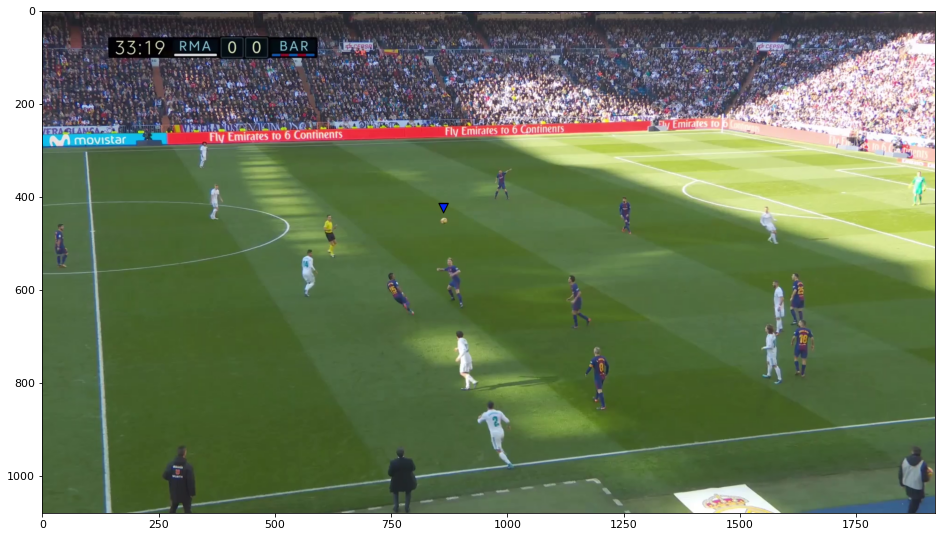

In [ ]:
# initiate annotators
ball_marker_annotator = MarkerAnntator(color=BALL_MARKER_FILL_COLOR)
# player_marker_annotator = MarkerAnntator(color=PLAYER_MARKER_FILL_COLOR)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(), 
    names=model.names)

# postprocess results
ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
    player_detections=player_detections,
    ball_detections=ball_detections,
    proximity=PLAYER_IN_POSSESSION_PROXIMITY)

# annotate video frame
annotated_image = frame.copy()
annotated_image = ball_marker_annotator.annotate(
    image=annotated_image, 
    detections=ball_detections)
# annotated_image = player_marker_annotator.annotate(
#     image=annotated_image, 
#     detections=[player_in_possession_detection] if player_in_possession_detection else [])

# plot video frame
plot_image(annotated_image, 16)
     

Full video

In [ ]:

from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)
    
video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int
        

# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path, 
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
        fps=video_config.fps, 
        frameSize=(video_config.width, video_config.height), 
        isColor=True
    )
     

Full video tracking

In [ ]:
from typing import List

import numpy as np

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we 
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x, 
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [ ]:
# text annotator to display tracker_id
@dataclass
class TextAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation
            if detection.tracker_id is None:
                continue

            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.7, 
                thickness=self.text_thickness)
            width, height = size
            
            # calculate text background position
            center_x, center_y = detection.rect.top_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10
            
            # draw background
            annotated_image = draw_point(
                image=annotated_image, 
                rect=Rect(x=x+15, y=y-28, width=width, height=height).pad(padding=0), 
                color=self.background_color)
            
            # draw text
            annotated_image = draw_text(
                image=annotated_image, 
                anchor=Point(x=x+ height, y=y-10), 
                text=str(detection.tracker_id), 
                color=self.text_color, 
                thickness=self.text_thickness)
        return annotated_image

Put everything together

In [ ]:
SOURCE_VIDEO_PATH = f"/content/test-video3.mp4"
TARGET_VIDEO_PATH = f"content/final/finaltest.mp4"

In [ ]:
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=30, 
    width=1920, 
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH, 
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))


# initiate annotators
base_annotator = BaseAnnotator(
    colors=[
        BALL_COLOR,
        PLAYER_COLOR,
        PLAYER_COLOR,
        REFEREE_COLOR
    ], 
    thickness=THICKNESS)

player_goalkeeper_text_annotator = TextAnnotator(
    PLAYER_COLOR, text_color=Color(255, 255, 255), text_thickness=2)
referee_text_annotator = TextAnnotator(
    REFEREE_COLOR, text_color=Color(0, 0, 0), text_thickness=2)

ball_marker_annotator = MarkerAnntator(
    color=BALL_MARKER_FILL_COLOR)
# player_in_possession_marker_annotator = MarkerAnntator(
#     color=PLAYER_MARKER_FILL_COLOR)


# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator, total=750):

      # run detector
      results = model(frame, size=1280)
      detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)

      # filter detections by class
      ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
      referee_detections = filter_detections_by_class(detections=detections, class_name="referee")
      goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
      player_detections = filter_detections_by_class(detections=detections, class_name="player")

      player_goalkeeper_detections = player_detections + goalkeeper_detections
      tracked_detections = player_detections + goalkeeper_detections + referee_detections

      # calculate player in possession
      player_in_possession_detection = get_player_in_possession(
        player_detections=player_goalkeeper_detections,
        ball_detections=ball_detections,
        proximity=PLAYER_IN_POSSESSION_PROXIMITY)

      # track
      tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
      )
      tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

      tracked_referee_detections = filter_detections_by_class(detections=tracked_detections, class_name="referee")
      tracked_goalkeeper_detections = filter_detections_by_class(detections=tracked_detections, class_name="goalkeeper")
      tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")

      # annotate video frame
      annotated_image = frame.copy()
      annotated_image = base_annotator.annotate(
        image=annotated_image, 
        detections=tracked_detections)

      annotated_image = player_goalkeeper_text_annotator.annotate(
        image=annotated_image, 
        detections=tracked_goalkeeper_detections + tracked_player_detections)
      annotated_image = referee_text_annotator.annotate(
        image=annotated_image, 
        detections=tracked_referee_detections)

      annotated_image = ball_marker_annotator.annotate(
        image=annotated_image, 
        detections=ball_detections)
      # annotated_image = player_marker_annotator.annotate(
      #     image=annotated_image, 
      #     detections=[player_in_possession_detection] if player_in_possession_detection else [])
    # save video frame
      video_writer.write(annotated_image)

# close output video
video_writer.release()